In [1]:
import sys
sys.path.append('..')

In [2]:
from common.utility import show_implementation
from module.utility import show_images, make_segments
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
rose_image_rgb = np.array(Image.open(
    'images/rose.jpg').resize((288, 216)).convert('RGB'))

In [4]:
np.random.seed(42)

# Segmentation
Segmentation is the process of separating an image into coherent regions/objects.
This include separating an subject from the background, or decomposing a scene into multiple objects.

## Toy Example

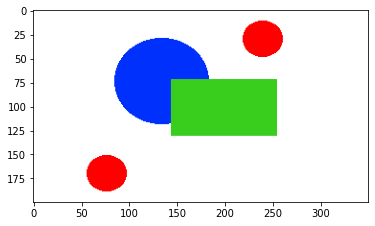

In [5]:
shape_image_rgb = np.array(Image.open('images/shapes.png').convert('RGB'))
plt.imshow(shape_image_rgb)

Suppose we wish to segment the above image into their respective shapes.
As we have established that [intensity carries much of the information in an image](./introduction.ipynb#intensity-vs-colour),
we can use the greyscale image find its corresponding [image histogram](./point_processing.ipynb#image-histogram).

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  5603.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,  2520.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 

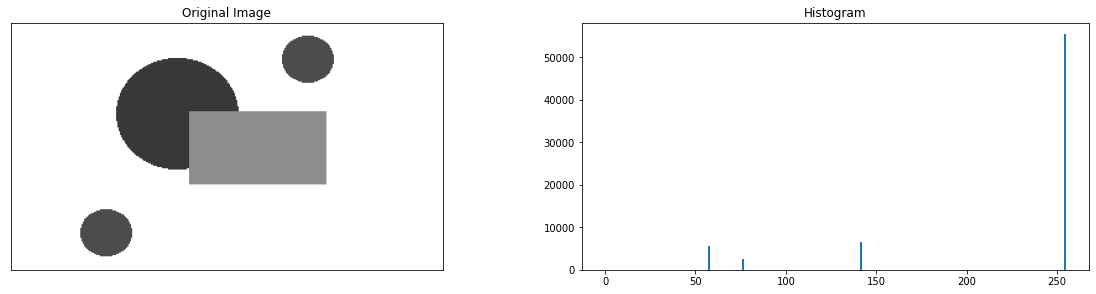

In [6]:
shape_image_grey = np.array(Image.open('images/shapes.png').convert('L'))

f = plt.figure(figsize=(20, 10))
ax11 = f.add_subplot(221)
ax12 = f.add_subplot(222)

ax11.title.set_text('Original Image')
ax11.imshow(shape_image_grey, cmap='gray', vmin=0, vmax=255)
ax11.xaxis.set_visible(False)
ax11.yaxis.set_visible(False)

ax12.title.set_text('Histogram')
ax12.hist(shape_image_grey.ravel(), bins=range(256))

From this, we can clearly see 4 distinct pixel values, and thus we can easily map each pixel value to an object label.

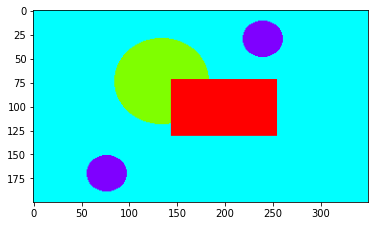

In [7]:
mapping = {intensity: label for label,
           intensity in enumerate(set(shape_image_grey.ravel()))}
labelled_image = np.vectorize(lambda x: mapping[x])(shape_image_grey)

plt.imshow(make_segments(labelled_image))

(To show the segments, we map each label to different hues in the colour spectrum)

However, images typically are not so easy to segment.
For example, if there is noise in the image, then this segmentation method is insufficient.

(array([1.7000e+01, 2.0000e+00, 0.0000e+00, 4.0000e+00, 4.0000e+00,
        7.0000e+00, 3.0000e+00, 4.0000e+00, 7.0000e+00, 7.0000e+00,
        8.0000e+00, 1.1000e+01, 5.0000e+00, 6.0000e+00, 9.0000e+00,
        1.3000e+01, 1.6000e+01, 2.1000e+01, 2.0000e+01, 1.9000e+01,
        2.6000e+01, 2.6000e+01, 4.0000e+01, 2.3000e+01, 2.3000e+01,
        2.8000e+01, 2.7000e+01, 4.6000e+01, 4.4000e+01, 5.0000e+01,
        5.7000e+01, 6.2000e+01, 5.9000e+01, 6.2000e+01, 7.3000e+01,
        7.3000e+01, 6.5000e+01, 8.0000e+01, 7.3000e+01, 8.7000e+01,
        1.0500e+02, 1.0500e+02, 1.1000e+02, 9.3000e+01, 1.0400e+02,
        1.0100e+02, 1.2400e+02, 1.3100e+02, 1.0800e+02, 1.2500e+02,
        1.2600e+02, 1.2100e+02, 1.3200e+02, 1.3600e+02, 1.5800e+02,
        1.3500e+02, 1.3800e+02, 1.4500e+02, 1.5800e+02, 1.2900e+02,
        1.3700e+02, 1.4400e+02, 1.5300e+02, 1.3200e+02, 1.2500e+02,
        1.4200e+02, 1.3800e+02, 1.5200e+02, 1.3500e+02, 1.2400e+02,
        1.6200e+02, 1.1900e+02, 1.4900e+02, 1.14

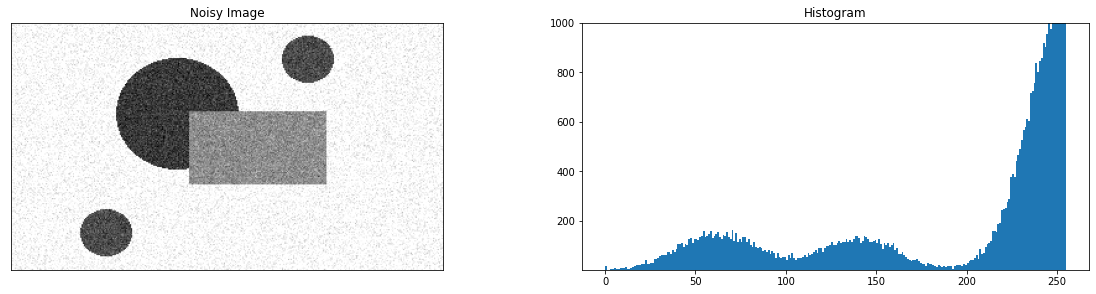

In [8]:
from module.add_noise import gaussian_noise

noisy_image = gaussian_noise(shape_image_grey)

f = plt.figure(figsize=(20, 10))
ax11 = f.add_subplot(221)
ax12 = f.add_subplot(222)

ax11.title.set_text('Noisy Image')
ax11.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
ax11.xaxis.set_visible(False)
ax11.yaxis.set_visible(False)

ax12.title.set_text('Histogram')
ax12.set_ylim(1000)
ax12.invert_yaxis()
ax12.hist(noisy_image.ravel(), bins=range(256))

Now, we cannot find a clear mapping from intensity values to object labels, because the same intensity value may be present in multiple objects, indicated by the overlaps in the curves.

## Clustering
**Clustering** is the act of grouping similar data points, and representing them with a single label.
This is similar to our goal of segmentation.

To perform clustering, we need to determine two factors:

1. Data features
    * We need to represent the pixel as a certain set of features (such as intensity values, RGB values, *etc*)
2. Distance measure
    * We need a method of comparing two pixels for their similarity/distance from each other, using the features we established above

Note that this means that for clustering, we are usually working mainly in the **feature space** of the image, and not the original image itself.
The feature could be a single value (thus 1 dimensional), such as intensity, or multiple values such as each of the RGB channel (thus multi-dimensional).

## K-means clustering


From the histogram, we can see that each peak corresponds to a segment in the original image.
Thus, we wish to find the center of each "hump", such that each of the center can be the representative of the pixels close to it.
Hence, the best cluster centers will minimize the distance between each points and their corresponding centers.

However, notice that we are in a dilemma.
Because to find the correct centers, we need find the group membership of the pixels to compute the mean of the group.
But to find the group membership of the pixels, we need to know the cluster centers to assign each pixel to the closest center.

To resolve this issue, we randomly assign the initial value for the centers.
Then we perform our clustering based on these centers, and continually improve our center values.
Hence, the procedure is as follows:
1. Decide on number of cluster to have
2. Randomly initialize that many cluster centers
3. For each pixel in the feature space, assign it the label corresponding to the center that it is closest to
4. For each label corresponding to a center, compute the new center using the average of the feature values of the pixel assigned to it
5. Repeat 3-5 until convergence

In [9]:
from module.kmeans import kmeans
import module.kmeans as km
show_implementation(km.make_centers)

def make_centers(num_clusters, features):
    feature_maxes = features.max(axis=0).max(axis=0)
    if len(features.shape) == 2:
        feature_maxes = [feature_maxes]
    centers = np.random.rand(num_clusters, len(feature_maxes))
    for i, m in enumerate(feature_maxes):
        centers[:, i] = centers[:, i] * m
        
    return centers


Firstly, we randomize the centers of the clusters.

In [10]:
show_implementation(km.get_labels)

def get_labels(features, centers):
    num_features = centers.shape[1]
    tree = KDTree(centers)
    _, labels = tree.query(features.reshape((-1, num_features)), workers=-1)
    return labels.reshape(features.shape[:2])


Then, for each pixels, we find the cluster that it is nearest to and assign it that label.

We use `KDTree` in our implementation.
It merely is a data structure that dramatically speeds up the querying for the nearest neighbour.

In [11]:
show_implementation(km.get_next_centers)

def get_next_centers(curr_centers, features):
    labels = get_labels(features, curr_centers)
    new_centers = np.array([[features[labels==i].mean(axis=0)] for i in range(len(curr_centers))])
    new_centers = new_centers.reshape(curr_centers.shape)
    return new_centers


For each label, we find all the associated pixels and calculate their mean.
These means will be the value for the new centers for the next iteration.

In [12]:
show_implementation(kmeans)

def kmeans(features: np.ndarray, num_clusters: int, initial_centers: np.ndarray=None, epsilon: float=1e-6) -> (np.ndarray, np.ndarray):
    if initial_centers is None:
        initial_centers = make_centers(num_clusters, features)
    
    assert initial_centers.shape[-1] == features.shape[-1], f"Centers dimension ({initial_centers.shape}) does not match feature space ({features.shape})"

    centers = initial_centers
    diff = float('infinity')
    while diff > epsilon:
        new_centers = get_next_centers(centers, features)
        diff = ((centers - new_centers)**2).sum()
        centers = new_centers
        
    return get_labels(features, centers), centers


Putting it all together, we get the above.

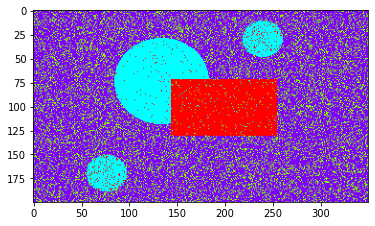

In [13]:
features = noisy_image
num_clusters = 4
initial_centers = km.make_centers(num_clusters, features)
centers = initial_centers
diff = float('infinity')
prev_centers = []
i = 0
while diff > 1e-6:
    if i % 3 == 0 and diff > 1:
        prev_centers.append(centers)
    i += 1
    new_centers = km.get_next_centers(centers, features)
    diff = ((centers - new_centers)**2).sum()
    centers = new_centers

labelled_image = km.get_labels(features, centers)
plt.imshow(make_segments(labelled_image))

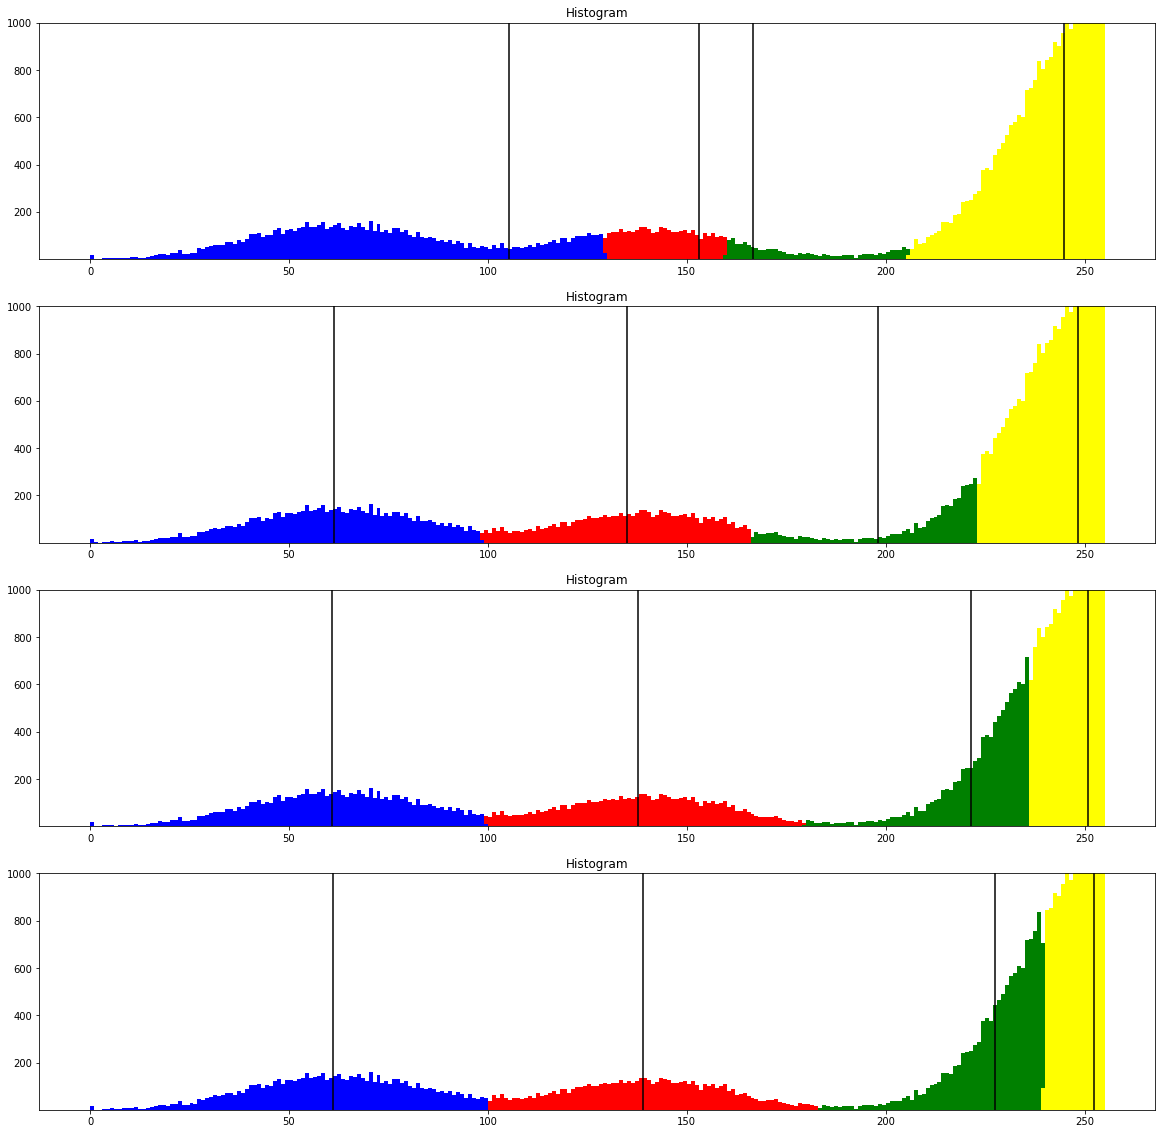

In [14]:
f = plt.figure(figsize=(20, len(prev_centers) * 5))

for i, p_center in enumerate(prev_centers):
    ax = f.add_subplot(len(prev_centers), 1, i+1)
    ax.title.set_text('Histogram')
    ax.set_ylim(1000)
    ax.invert_yaxis()
    colors = ['red', 'blue', 'green', 'yellow', 'cyan']

    labels = km.get_labels(noisy_image, p_center)
    for j in range(num_clusters):
        ax.hist(noisy_image[labels == j].ravel(),
                bins=range(256), color=colors[j])
        ax.axvline(x=p_center[j], color='black')

The dark lines indicates the location of the centers, and each histogram is coloured based on its labeling at that iteration of clustering.
At our final stage, we can see that our centers are approximately at the peak of each density (at least for the red and the blue, and somewhat the yellow), as we desired.


Notice that the segmentation for the large circle, rectangle and background is done rather well.
However, the small circle is done rather poorly.
Notice that despite there being 4 observed clusters (large circle, small circle, rectangle and background), we failed to assign the large and small circles different labels.
This is because the system assigned the unique label to the noise instead, since the small circle and large circle looks similar in the intensity plot.

One way to resolve this (for this example) is to cluster using 3 features (RGB) instead of 1 (intensity).
Since the small circle is clearly red and thus a different colour from the other segments, it is likely to be its own cluster if we clustered using 3 features.

Hence, consider the below noisy RGB image.

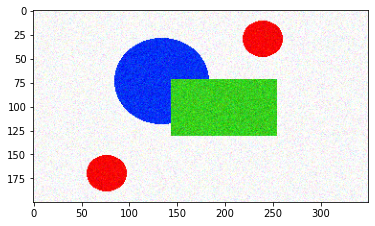

In [15]:
noisy_rgb_image = gaussian_noise(shape_image_rgb)

plt.imshow(noisy_rgb_image/255)

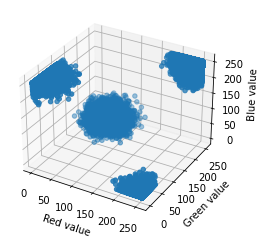

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

red, green, blue = noisy_rgb_image[:, :, 0].ravel(
), noisy_rgb_image[:, :, 1].ravel(), noisy_rgb_image[:, :, 2].ravel()

ax.scatter(red, green, blue)

ax.set_xlabel('Red value')
ax.set_ylabel('Green value')
ax.set_zlabel('Blue value')

plt.show()

From the feature space plot, we can clearly see that there are 4 distinct cluster.

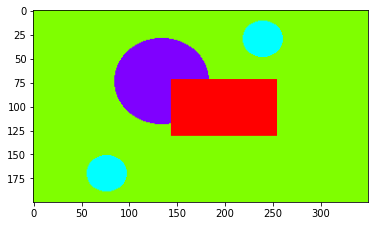

In [17]:
labelled_image, _ = kmeans(noisy_rgb_image, 4)

plt.imshow(make_segments(labelled_image))

Hence, when we cluster using RGB as the feature space, we obtain our desired segmentation.

However, note that both small circles have the same RGB value, and thus are assigned the same label.
Depending on the use case, there might be cases where we wish to assign them different labels.
One example would be if there is an image of many black cats, and we wish to count how many cats there are, thus assigning them different labels will be desirable.

To obtain this, we can augment the feature space with X,Y position of the pixel, such that pixels that are spatially close together is more likely to be in the same cluster.

In [18]:
from module.feature import make_pos_intensity_feature
show_implementation(make_pos_intensity_feature)

def make_pos_intensity_feature(grey_image: np.ndarray, factor: float=1) -> np.ndarray:
    height, width = grey_image.shape
    result = np.zeros((height, width, 3))
    ys = np.tile(np.arange(height), (width, 1)).transpose()
    xs = np.tile(np.arange(width), (height, 1))
    result[:,:,0] = ys
    result[:,:,1] = xs
    result[:,:,2] = grey_image * factor
    
    return result


We scale the intensity value by a factor so that we can adjust how much the clustering cares about spatial distance vs intensity difference.

In [19]:
pos_intensity_features = make_pos_intensity_feature(noisy_image, factor=1.4)

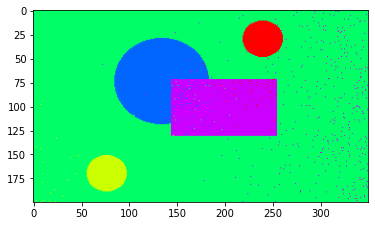

In [20]:
cherrypicked_centers = np.array([[69.5361116, 127.72223203,  80.50671982],
                                 [102.38127376, 176.34949337, 346.2845895],
                                 [31.85159817, 239.01369863, 106.5940861],
                                 [169.37675507,  75.68174727, 109.44135685],
                                 [101.06676514, 204.80251108, 202.76740004]])

labelled_image, centers = kmeans(
    pos_intensity_features, 5, cherrypicked_centers)
plt.imshow(make_segments(labelled_image))

Hence, we obtain our desired segmentation as aboves.
Note that the above result is heavily cherrypicked.
Because k-means clustering often fall into local minimums, the end results is heavily dependent on the starting centers and unlikely to be optimal, hence it is expected that the segmentation is not "perfect" as we can see above.

Since we know that we cluster better on RGB (for this particular image), we can actually cluster on the feature space where it is RGB with X,Y position, given us a 5 dimensional feature space.

In [21]:
from module.feature import make_pos_rgb_feature
show_implementation(make_pos_rgb_feature)

def make_pos_rgb_feature(rgb_image: np.ndarray, factor:float=1) -> np.ndarray:
    height, width = rgb_image.shape[:2]
    result = np.zeros((height, width, 5))
    ys = np.tile(np.arange(height), (width, 1)).transpose()
    xs = np.tile(np.arange(width), (height, 1))
    result[:,:,0] = ys 
    result[:,:,1] = xs
    result[:,:,2:5] = rgb_image * factor
    
    return result


In [22]:
pos_rgb_features = make_pos_rgb_feature(noisy_rgb_image, 1.8)

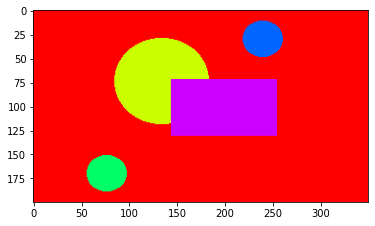

In [23]:
cherry_picked_centers = np.array(
    [[102.38725419, 177.12521689, 444.7057452, 444.72578074, 444.67933502],
     [101., 199., 102.56678541, 370.63426987, 55.10734393],
     [169.5, 76.5, 444.05886253, 13.68301841, 13.27143447],
     [29.5, 239.5, 444.71423329, 13.52361166, 14.38169692],
     [69.23594503, 127.36123505, 14.29474537, 86.14123823, 440.4526699]]
)

labelled_image, centers = kmeans(pos_rgb_features, 5, cherry_picked_centers)

plt.imshow(make_segments(labelled_image))

### Pros
* Simple, thus fast and easy to compute

### Cons
* Require prerequisite knowledge on the number of clusters in the image
* Sensitive to initial centers
* Sensitive to outliers
* Assumes clusters are spherical
* Assumes means of clusters are meaningful

#### Sensitivity to outliers

Consider the below image.

(array([36.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

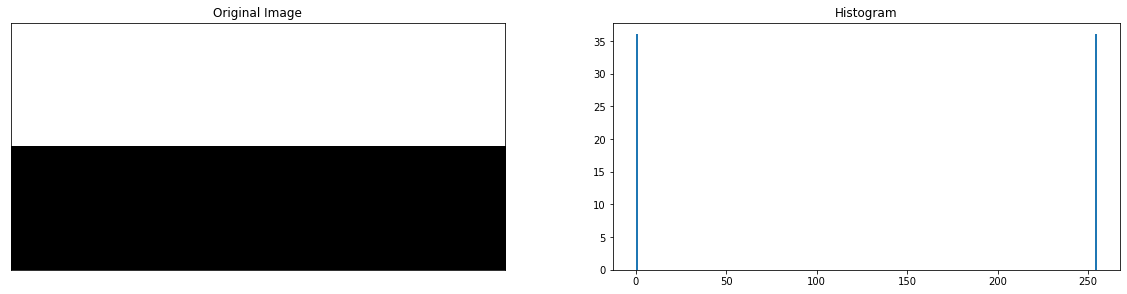

In [24]:
toy_image = np.vstack((np.ones((3, 12, 1)) * 255, np.zeros((3, 12, 1))))

f = plt.figure(figsize=(20, 10))
ax11 = f.add_subplot(221)
ax12 = f.add_subplot(222)

ax11.title.set_text('Original Image')
ax11.imshow(toy_image, cmap='gray', vmin=0, vmax=255)
ax11.xaxis.set_visible(False)
ax11.yaxis.set_visible(False)

ax12.title.set_text('Histogram')
ax12.hist(toy_image.ravel(), bins=range(256))

In [25]:
num_clusters = 2
_, centers = kmeans(toy_image, num_clusters)
print(centers)

[[  0.]
 [255.]]


Through k-means clustering over 2 clusters, we get our desired centers at 0 and 255.

Now suppose that we perturb the image by adding merely 2 grey pixels.

(array([35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

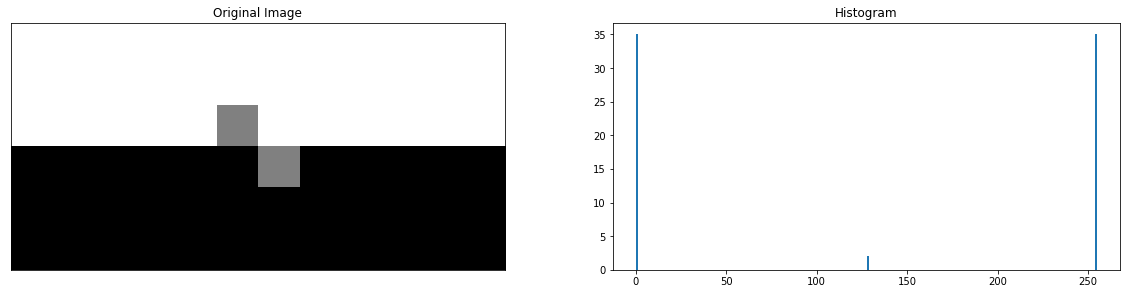

In [26]:
toy_image[3][6] = 128
toy_image[2][5] = 128
f = plt.figure(figsize=(20, 10))
ax11 = f.add_subplot(221)
ax12 = f.add_subplot(222)

ax11.title.set_text('Original Image')
ax11.imshow(toy_image, cmap='gray', vmin=0, vmax=255)
ax11.xaxis.set_visible(False)
ax11.yaxis.set_visible(False)

ax12.title.set_text('Histogram')
ax12.hist(toy_image.ravel(), bins=range(256))

In [27]:
num_clusters = 2
_, centers = kmeans(toy_image, num_clusters)
print(centers)

[[  0.        ]
 [248.13513514]]


Now notice that the center that was previously at 0 has (somewhat) significantly shifted to 6.92.

This happens because k-means takes the mean of the pixels for each label.
And since mean is heavily influenced by outliers, so is k-means clustering.

## Mean-shift clustering
To solve the issue with k-means, where it requires pre-requisite knowledge of the number of clusters, we can turn to **mean-shift clustering**

The idea of mean-shift clustering is simple:
1. For each point in the feature space, create a window around it
2. Shift the center of the window to the centroid of all the points within the window
3. Repeat until convergence

### Implementation

In [28]:
import module.mean_shift as ms

show_implementation(ms.make_centers)

def make_centers(features: np.ndarray, bandwidth: float, threshold: int) -> np.ndarray:
    compressed = np.round(features.reshape(-1, features.shape[-1]) /bandwidth)
    unique, counts = np.unique(compressed, axis=0, return_counts=True)
    
    centers = np.array([x for x, c in zip(unique, counts) if c >= threshold])
    return centers * bandwidth + bandwidth/2


For speedup, instead if initializing each point as a center, we divide the feature space into regions of size `bandwith`, and we only select those regions with `threshold` number of points as centers.

In [29]:
show_implementation(ms.get_next_centers)

def get_next_centers(centers, tree, bandwidth):
    indices = tree.query_ball_point(centers, bandwidth, workers=-1)
    new_centers = np.array([tree.data[ind].mean(axis=0) for ind in indices if len(ind) > 0])
    return new_centers


For each center, we find all the points that are within its bandwidth and shift the center to the mean.

In [30]:
show_implementation(ms.prune_centers)

def prune_centers(centers, prune_radius):
    center_tree = KDTree(centers)
    indices_to_remove = np.unique(np.array([i for i, _ in center_tree.query_pairs(prune_radius)]))
    pruned_centers = np.delete(centers, indices_to_remove, axis=0) if indices_to_remove.size > 0 else centers
    
    return pruned_centers


For speedup, we assume that all centers that are within `prune_radius` of each other will end up at the same location the end of the algorithm, thus we can safely remove all but one of them.

In [31]:
show_implementation(ms.mean_shift)

def mean_shift(features: np.ndarray, bandwidth: float, threshold: int, prune_radius: float, 
               epsilon: float = 1e-6) -> (np.ndarray, np.ndarray):
    initial_centers = make_centers(features, bandwidth, threshold)
    tree = KDTree(features.reshape((-1, features.shape[-1])))
    assert initial_centers.shape[-1] == features.shape[-1], f"Centers dimension ({initial_centers.shape}) does not match feature space ({features.shape})"

    centers = initial_centers
    diff = float('infinity')
    while diff > epsilon * bandwidth:
        new_centers = get_next_centers(centers, tree, bandwidth)
        new_centers = prune_centers(new_centers, prune_radius)
        
        if centers.shape != new_centers.shape:
            centers = new_centers
            continue
        else:
            diff = ((centers - new_centers)**2).sum()
            centers = new_centers
    return get_labels(features, centers), centers


Putting it all together, we get the above.

In [32]:
pos_rgb_features = make_pos_rgb_feature(noisy_rgb_image, 1.1)
labels, centers = ms.mean_shift(pos_rgb_features, 30, 110, 60)

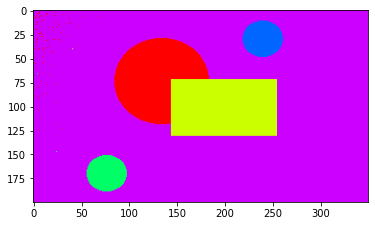

In [33]:
plt.imshow(make_segments(labels))

To visualize the trajectory of the centers in mean-shift clustering, we can observe its effect on a 2D feature space as per below:

In [34]:
from scipy.spatial import KDTree

features = noisy_rgb_image[:, :, 0:2].reshape((-1, 2))
bandwidth, threshold, prune_radius = 30, 10, 5
epsilon = 1e-6

initial_centers = ms.make_centers(features, bandwidth, threshold)
tree = KDTree(features.reshape((-1, features.shape[-1])))
assert initial_centers.shape[-1] == features.shape[-1], f"Centers dimension ({initial_centers.shape}) does not match feature space ({features.shape})"

prev_centers = []
centers = initial_centers
diff = float('infinity')
while diff > epsilon * bandwidth:
    new_centers = ms.get_next_centers(centers, tree, bandwidth)
    new_centers = ms.prune_centers(new_centers, prune_radius)
    prev_centers.append(new_centers)
    if centers.shape != new_centers.shape:
        centers = new_centers
        continue
    else:
        diff = ((centers - new_centers)**2).sum()
        centers = new_centers

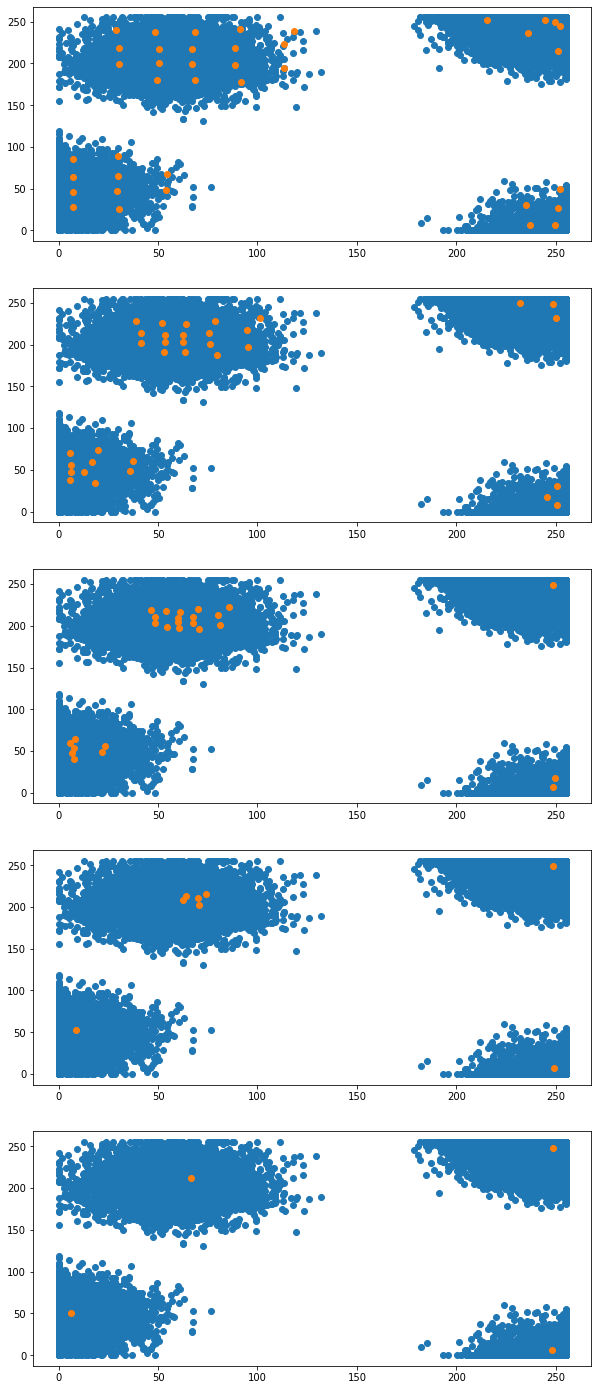

In [35]:
prev_centers = prev_centers[:5]
f = plt.figure(figsize=(10, len(prev_centers) * 5))

for i, p_center in enumerate(prev_centers):
    ax = f.add_subplot(len(prev_centers), 1, i+1)
    ax.scatter(*features.reshape((-1, 2)).T)
    ax.scatter(*p_center.T)

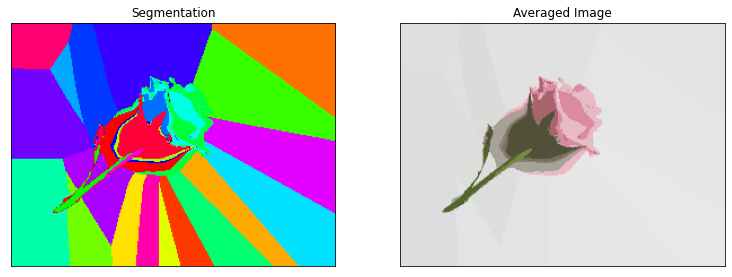

In [36]:
features = make_pos_rgb_feature(rose_image_rgb)
labels, centers = ms.mean_shift(features, 30, 30, 10)


def average_labelled_clusters(labels, centers, image):
    rgb_mapping = np.array([image[labels == l].mean(axis=0)
                           for l in np.unique(labels)]).astype(np.uint8)
    result = np.zeros(image.shape, dtype=np.uint8)

    for i, j in np.ndindex(labels.shape):
        result[i, j, :] = rgb_mapping[labels[i, j]]
    return result


averaged_image = average_labelled_clusters(labels, centers, rose_image_rgb)

show_images((make_segments(labels), "Segmentation"),
            (averaged_image, "Averaged Image"))

### Pros
* A general method for segmentation
* No assumption about cluster shape
* Its only parameter (in the original algorithm) `bandwidth/window size` has physical meaning
* Does not require prior knowledge on the number of clusters
* Robust to outliers

### Cons
* Output heavily depends on bandwidth, and finding the optimum bandwidth is non-trivial
* Computationally expensive
* Scales poorly with feature space dimension

## Simply Linear Iterative Clustering (SLIC)
The goal of SLIC is to form **super-pixels** in the image.
Super-pixels are groups of pixels in the image that shares some characteristics.
In some sense, we could have viewed each segment obtained from k-means clustering as a super-pixel.

The process of SLIC is as follows:
### Initialization
1. Determine the number of super-pixels we want ($n_{sp}$)
2. Compute the distance between super-pixels (s = $\sqrt{n_p/n_sp}$), where $n_p$ is the number of pixel in the image.
3. Initialize a grid of $n_sp$ pixels, each equally spaced apart
4. Adjust each pixel to the point of the lowest gradient magnitude in a $3 \times 3$ area
    * This is to ensure that pixels are placed on a relatively "flat" region
    * Clustering because problematic when the center is on an edge/region of high noise
5. Using the RGB value and location of each pixel, they become the initial centers in our feature space
6. For each pixel $p$ in the image, intialize the distance $D(p) = \infty$ and label $L(p) = -1$ 

In [37]:
import module.slic as slic

show_implementation(slic._calc_distance)
show_implementation(slic._make_initial_centers)

def _calc_distance(image: np.ndarray, num_super_pixels: int):
    height, width = image.shape[:2]
    return int(np.ceil(np.sqrt(height * width / num_super_pixels)))
def _make_initial_centers(image: np.ndarray, s: int):
    height, width = image.shape[:2]
    return np.array([(i + s//2, j + s//2) for j in range(0, width, s) for i in range(0, height, s)])


In [38]:
show_implementation(slic.make_slic_centers)

def make_slic_centers(image: np.ndarray, num_super_pixels: int):
    s = _calc_distance(image, num_super_pixels)
    initial_centers = _make_initial_centers(image, s)
    gradient_magnitude, _ = compute_gradient(to_greyscale(image))
    centers = _shift_centers(initial_centers, gradient_magnitude)
    assert centers.shape[0] == num_super_pixels, "Number of super pixel is not evenly divided across the image"
    return centers, s


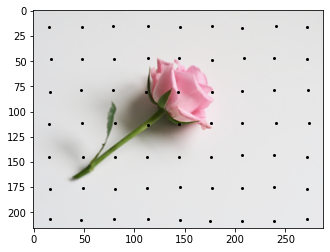

In [39]:
centers, _ = slic.make_slic_centers(rose_image_rgb, 63)

plt.plot([centers[:, 1]], [centers[:, 0]], 'ko', markersize=2)
plt.imshow(rose_image_rgb)

Thus, this is the centers that we get after the initialization phase.
Note that the centers are spread somewhat evenly, but not exactly evenly due to the shifting to a lower gradient.

### Clustering
1. For each pixel, assign it the label corresponding to the center that it is closest to, **only if it is in a $2s\times 2s$ neighbourhood of that center and the distance is less than $D(p)$**. Update $D(p)$ and $L(p)$ accordingly
    * This ensures that clusters are "tight"
2. Update the centers as per k-means
3. Repeat step 1-3 until convergence as per k-means

Notice that SLIC is very similar to k-means, with its main difference being the initialization process and the distance restriction on clustering.
Also, each pixels which were originally centers will never change its label because $D(p) = 0$, even if the center associated with the label moves further from it.

In [40]:
show_implementation(slic._get_labels)

def _get_labels(features: np.ndarray, centers: np.ndarray,
                prev_distances: np.ndarray,
                prev_labels: np.ndarray, s: int) -> (np.ndarray, np.ndarray):
    _, num_features = centers.shape
    tree = KDTree(centers)
    queried_dist, queried_labels = tree.query(
        features.reshape((-1, num_features)), k=centers.shape[0])

    filtered_dist, filtered_labels = _filter_outside(features, s, queried_dist, queried_labels, centers)

    prev_distances = prev_distances.reshape(filtered_dist.shape)
    prev_labels = prev_labels.reshape(filtered_labels.shape)

    labels = np.where(filtered_dist < prev_distances,
                      filtered_labels, prev_labels)
    distances = np.minimum(filtered_dist, prev_distances)

    return labels.reshape(features.shape[:2]), distances


In [41]:
show_implementation(slic._filter_outside)

def _filter_outside(features: np.ndarray, s: int,
                    distances: np.ndarray,
                    labels: np.ndarray,
                    centers: np.ndarray) -> (np.ndarray, np.ndarray):
    yx = features[:,:,:2]
    yxs = np.repeat(yx[:, : , np.newaxis], labels.shape[-1], axis=2)
    
    center_yx = centers[:,:2][labels]
    yxs = yxs.reshape(center_yx.shape)
    
    is_inside = np.all(np.abs(yxs - center_yx) <= s, axis=2)
    
    assert np.all(np.any(is_inside, axis=1)), f"No candidate found among top-{labels.shape[-1]} candidates"
    
    indices = np.apply_along_axis(np.argmax, 1, is_inside)
    return distances[range(len(indices)),indices], labels[range(len(indices)),indices]


Deciding the labels is similar to that of k-means, except we include a step to reject all labels which are not within the neighbourhood of the point.

In [42]:
show_implementation(slic._get_next_centers)

def _get_next_centers(curr_centers: np.ndarray, features: np.ndarray, labels: np.ndarray):
    new_centers = np.array([[features[labels == i].mean(axis=0)]
                           for i in range(len(curr_centers))])
    new_centers = new_centers.reshape(curr_centers.shape)
    return new_centers


In [43]:
show_implementation(slic.slic)

def slic(image: np.ndarray, num_super_pixels: int, factor: float = 1.0, epsilon: float = 1e-6) -> (np.ndarray, np.ndarray):
    centers, s = make_slic_centers(image, num_super_pixels)

    features = make_pos_rgb_feature(image, factor)
    feature_centers = features[centers[:, 0], centers[:, 1]]

    distances = np.ones((features.shape[:2])) * float('infinity')
    labels = np.ones((features.shape[:2]), dtype=np.int32) * -1

    centers = feature_centers
    diff = float('infinity')
    while diff > epsilon:
        labels, distances = _get_labels(features, centers, distances, labels, s)
        new_centers = _get_next_centers(centers, features, labels)
        diff = ((centers - new_centers)**2).sum()
        centers = new_centers

    return _get_labels(features, centers, distances, labels, s)[0], centers


Note that in original SLIC, their distance metric is $\sqrt{(d_R^2 + d_G^2 + d_B^2) + (d_X^2 + d_Y^2)c^2}$, where each of $d_x$ is the distance between the 2 pixels on the $x$ feature, with $c^2$ being the scaling factor which 
decide how much to weigh the spatial distance compared to the color distance.
We implemented it by scaling the ranges of the feature dimension itself rather than incorporating it in the distance metric, for ease of implementation and code reuse, which helps speeds up the code.

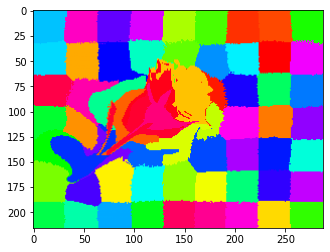

In [44]:
factor = 3.6
labels, centers = slic.slic(rose_image_rgb, num_super_pixels=63, factor=factor)
plt.imshow(make_segments(labels))

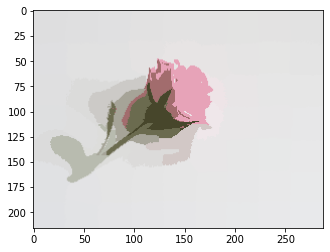

In [45]:
averaged_image = average_labelled_clusters(labels, centers, rose_image_rgb)
plt.imshow(averaged_image)

Now, we can replace each pixels with the RGB average value for that label, obtaining the above result.
As another step of post-processing, we can surround each super-pixel with a border, obtaining the below "stained-glass" effect.

In [46]:
def make_stained_glass_effect(labels, segmented_image):
    result = segmented_image.copy()
    for val in set(labels.ravel()):
        section = np.argwhere(labels == val)
        for y, x in section:
            window = labels[max(y - 1, 0): y+2, max(x - 1, 0): x+2]
            if np.any(window > val):
                result[y][x] = segmented_image[y][x]/2
    return result

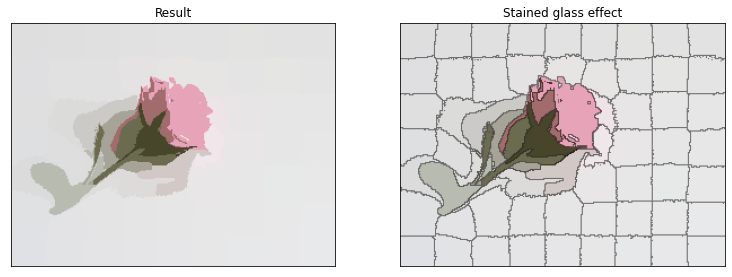

In [47]:
show_images((averaged_image, "Result"), (make_stained_glass_effect(
    labels, averaged_image), "Stained glass effect"))

For a comparison, we can initialized the SLIC centers and use k-means clustering instead, obtaining the below result.

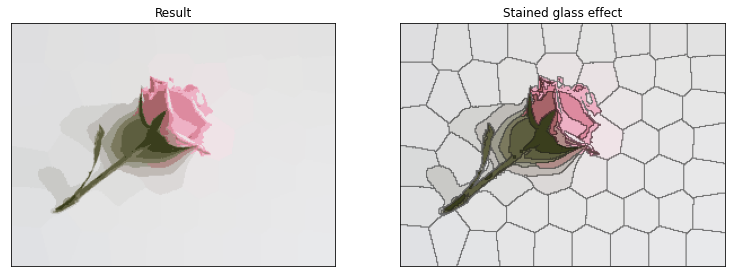

In [48]:
initial_centers, _ = slic.make_slic_centers(rose_image_rgb, 63)
features = make_pos_rgb_feature(rose_image_rgb)
feature_centers = features[initial_centers[:, 0], initial_centers[:, 1]]
labels, centers = kmeans(features, num_clusters=63,
                         initial_centers=feature_centers)

averaged_image = average_labelled_clusters(labels, centers, rose_image_rgb)

show_images((averaged_image, "Result"), (make_stained_glass_effect(
    labels, averaged_image), "Stained glass effect"))

Notice that the super-pixels are much more irregular and the boundaries of each cluster is not as clear as with SLIC.
This can explain its higher detail.

However, when using super-pixels, because the motivation was to have an abstract representation of the image, it may not be desirable to have such high level of detail in our result.